In [5]:
# f_name = '../../Genie_Transfer/Si/SI2019/SI04119.Chn'
# f_name = '../gamma/spectra/ALMERA-2016/alm_samp5_sedim_16.IEC'

In [6]:
# spec = Spec(f_name)
# spec.spec_parms.cnt_array_like.eval_smoo_cts.size

In [7]:
# 2022-Mar-24 Questão: o arquivo a seguir, criado no Windows, não abre no Linux.
# "cannot instantiate 'WindowsPath' on your system"
# pkl_file = 'gamma_results_df3_2022-03-22T19.34.57.xz' 

In [8]:
# 2022-Mar-24 Peguemos este que foi Linux-created:
# pkl_file_df1 = 'gamma_results_df1_2022-03-24T14.13.58.pkl' # 2022-Jun não abre mais...
pkl_file_df1 = 'gamma_results_df1_2022-03-07T18.20.36.xz' # 2022-Jun não abre mais no Mint Ipen 


In [9]:
# 2022-Abr-29 Questão: há arquivos que foram criados no Windows e não abrem no Linux.
# Mensagem: "cannot instantiate 'WindowsPath' on your system"
# 2022-Jun-23 Agora está dando outro problema:
# "Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/home/maduar/anaconda3/
#     lib/python3.9/site-packages/pandas/_libs/internals.cpython-39-x86_64-linux-gnu.so'>"
# pkl_df1 = pd.read_pickle(pkl_file_df1)
# Pulando para a linha que define o espectro a analisar, p/ex.:
# a_spec_name = '../../Genie_Transfer/Si/2018/CTP/CTP0908-2.Chn'

In [10]:
# pkl_df1

In [11]:
# spectra_df = pd.read_pickle(pkl_file)
# spectra_df

In [12]:
# spectra_df.count()

In [13]:
# spectra_df.count()[0]

In [26]:

# Testes:
# https://numpy.org/doc/stable/reference/random/generator.html#distributions
# x = np.linspace(0, 10, N) + rng.normal(loc=7, scale=0.05, size=N)
# y = np.linspace(22, 23, N)

x_step = 400
step_stretchness = 0.05
height = 1500
nch = 4096
x = np.linspace(0, nch-1, nch)
base_y = height * (special.erf(step_stretchness*(x-x_step))+1)/2
noisy_y = np.array([rng.normal(loc=yi, scale=np.sqrt(yi), size=None) for yi in base_y])

# Se quiser pegar um espectro real:
noisy_y = cntarr.y0s

# Busca do canal onde a altura do espectro se "estabiliza"
# https://numpy.org/doc/stable/reference/routines.sort.html#searching



In [ ]:
# 2022-Dez-21
# Aproveitar e adaptar o que segue para usar futuramente
# vários tipos de ajustes lmfit no radionuclide_analysis.ipynb


[[Model]]
    ((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) - Model(step, prefix='step_', form='erf'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 273
    # data points      = 26
    # variables        = 9
    chi-square         = 45604.1083
    reduced chi-square = 2682.59461
    Akaike info crit   = 212.211070
    Bayesian info crit = 223.533939
##  Warning: uncertainties could not be estimated:
    g2_center:       at boundary
[[Variables]]
    step_amplitude:  240.406827 (init = 70)
    step_center:     314.978346 (init = 310)
    step_sigma:     -0.52093506 (init = 2)
    g1_amplitude:    2848.63826 (init = 1400)
    g1_center:       306.599204 (init = 307)
    g1_sigma:        0.93821483 (init = 1.5)
    g1_fwhm:         2.20932704 == '2.3548200*g1_sigma'
    g1_height:       1211.28154 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:    12070.6196 (init = 400)
    g2_center:       315.000000 (init = 313)
    g

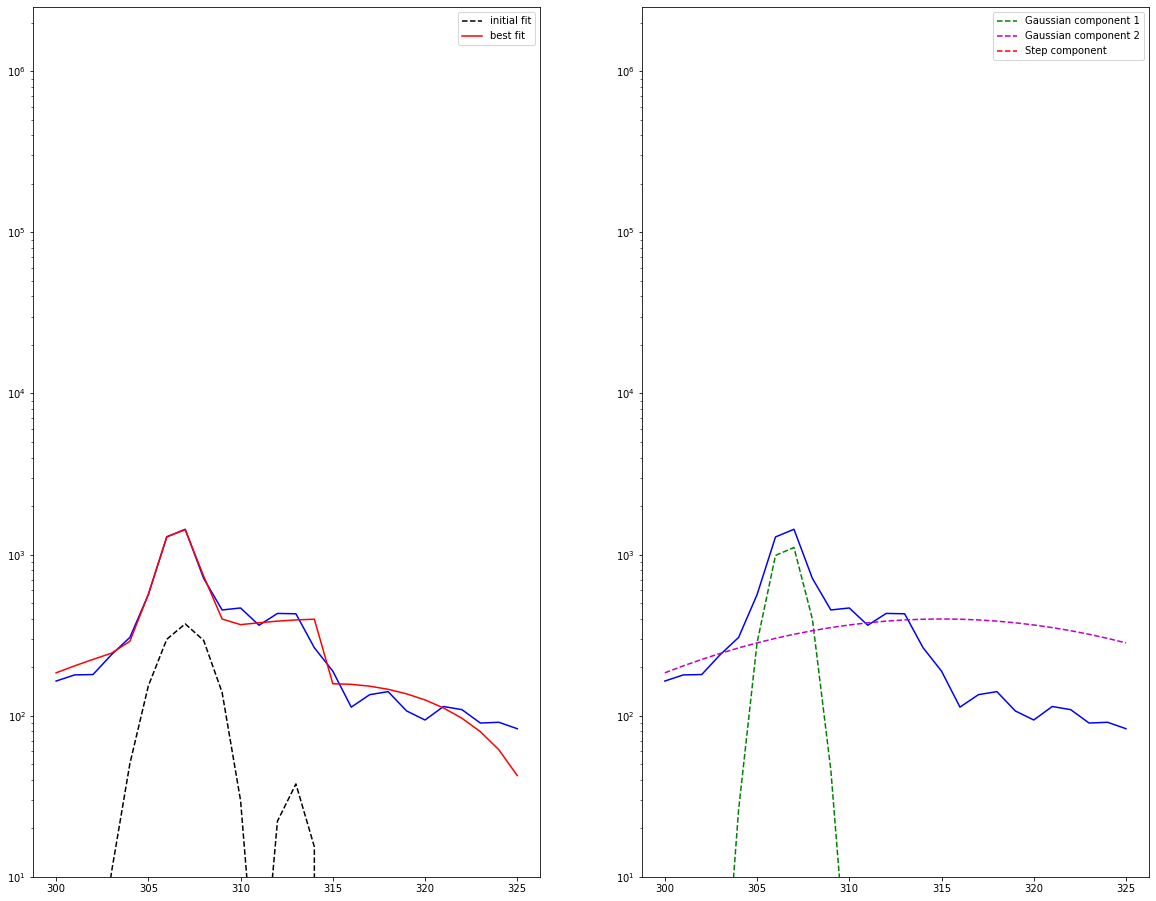

In [50]:
x = chans
y = counts

NameError: name 'counts' is not defined

In [72]:
# Após descontar a step_baseline:
y = cntarr.y0s - cntarr.step_baseline(y0s[0], y0s[-1], y0s)

NameError: name 'y0s' is not defined

In [ ]:
y[0:10]

In [ ]:
y[-11:-1]

In [ ]:
y.size

In [ ]:
# Agora usando algoritmo Tail do Genie

In [ ]:
def tailed_gaussian(x, cp, height, sigma, tail):
    if x >= cp - tail:
        fx = height * np.exp(-((x-cp)**2)/(2*sigma**2))
    else:
        fx = height * np.exp(tail*(2*x-2*cp+tail)/(2*sigma**2))
    return fx

In [ ]:
script = """
def tailed_gaussian(x, cp, height, sigma, tail):
    if x >= cp - tail:
        fx = height * np.exp(-((x-cp)**2)/(2*sigma**2))
    else:
        fx = height * np.exp(tail*(2*x-2*cp+tail)/(2*sigma**2))
    return fx
"""

In [ ]:
script = """
def mycurve(x, amp, cen, sig):
    loren = lorentzian(x, amplitude=amp, center=cen, sigma=sig)
    gauss = gaussian(x, amplitude=amp, center=cen, sigma=sig)
    return log(loren) * gradient(gauss) / gradient(x)
"""

In [ ]:
mod = ExpressionModel('mycurve(x, height, mid, wid)', init_script=script,
                      independent_vars=['x'])

In [ ]:
tailed_gaussian(0,1,2,3,4)

In [ ]:
y

In [ ]:
y

In [ ]:
mod = ExpressionModel('tailed_gaussian(x, cp, height, sigma, tail)', init_script=script,
                      independent_vars=['x'])

In [ ]:
pars = Parameters()

pars.update(mod.make_params())
pars['cp'].set(value=420, min=416, max=425)
pars['height'].set(value=1.0)
pars['sigma'].set(value=1.0, min=0.5, max=2)
pars['tail'].set(value=2e6, min=10)

init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.1))



In [ ]:
mod = ExpressionModel('tailed_gaussian(x, cp, height, sigma, tail)', init_script=script,
                      independent_vars=['x'])

In [ ]:
# https://docs.python.org/3.8/library/string.html#formatspec
# 2021-Jul-23 A formatação tem que ser exatamente assim para obter o que quero:
[print((item.size*'{:10.4f}      ').format(*item))
 for item in np.array([peaks_net, pk_hei_net, width_heights_net, widths_net]).T]

In [ ]:
# Para o cálculo da centroide:
# weighted_means = sum([ w*v for w,v in zip(weights, values)]) / sum( w*w )

In [ ]:
# width_heights_net = propts_net['width_heights']
# left_ips_net = propts_net['left_ips']
# right_ips_net = propts_net['right_ips']
# pk_hei_net = propts_net['peak_heights']
# promns_net = propts_net['prominences']
# widths_net = propts_net['widths']

In [ ]:
# https://docs.python.org/3.8/library/string.html#formatspec
# 2021-Jul-23 Assim seria melhor, mas não consigo pôr newline:
# print([(item.size*'{:10.4f}      '+'                                             ').format(*item)
#        for item in np.array([peaks_net, pk_hei_net, width_heights_net, widths_net]).T])

In [ ]:
2*np.sqrt(2*np.log(2))

In [ ]:
# 2021-Jul-27
# Exemplos de geração de aleatórios e indexação avançada de arrays

In [ ]:
# https://numpy.org/devdocs/reference/random/index.html#random-quick-start

In [ ]:
def gaussian_fw_fixed(x,*p):
    """Gaussian function.
    """
    # fgf: factor for gaussian with fwhm
#    fgf = 4.0 * np.log(2.0)
    # ng: number of gaussian in multiplet
    ng = int( len(p) / 3)
    a = 0.0
    for i in range(ng):
        fw, he, cn = p[3*i+0], p[3*i+1], p[3*i+2]
        a += he*np.exp(-fgf*(x-cn)**2/fw**2)
    return a

In [ ]:
# 2022-Mar-30: CONTINUAR DAQUI.

In [ ]:
# Localizar os picos pann.peaks_parms.peaks_net dentro de cada região pann.peaks_parms.net_regions:
all_matches = []
for nt_rg in pann.peaks_parms.net_regions:
    matches = [pk for pk in peaks_net if pk in range(nt_rg[0], nt_rg[1])]
    all_matches.append(matches)
all_matches

In [ ]:
net_regions = pann.peaks_parms.net_regions
net_regions

In [ ]:
internal_pk_chans = [all_matches[i]-net_regions[i][0] for i in range(len(all_matches))]
internal_pk_chans[0]

In [ ]:
net_y = pann.cnt_array_like.net_spec[slice(*pann.peaks_parms.net_regions[0])]
net_y

In [ ]:
net_regions

In [ ]:
# 2021-Jul-12
# Super loop!: Revisto em Jul-25
# 2022-Mar-30: Revisto novamente.
all_outs = []
useful_regs_inichan = []
for i_rg, nt_rg in enumerate(pann.peaks_parms.net_regions):
    print(nt_rg)
    net_y = pann.cnt_array_like.net_spec[slice(*nt_rg)]
    print('Canal inicial: ' + str(nt_rg[0]))
    print('Contagens líquidas na região: ' + str(net_y))
    print('Picos internos candidatos: ' + str(internal_pk_chans[i_rg]))
    if not len(internal_pk_chans[i_rg]):
        print('Sem picos.')
    elif 3*len(internal_pk_chans[i_rg]) > net_y.size:
        print('Muitos picos. Selecionar.')
    else:
        print('Poder resolver o multipleto.')
        an_out = resolve_multiplet(internal_pk_chans[i_rg], net_y)
        all_outs.append(an_out)
        useful_regs_inichan.append(nt_rg)
    print('------------------------------------------')

In [ ]:
all_matches

In [ ]:
all_outs

In [ ]:
useful_regs_inichan

In [ ]:
import pickle

# An arbitrary collection of objects supported by pickle.
data = useful_regs_inichan

with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# 2022-Mar-30 Parei aqui.
WSDEF waef WEF we 

In [ ]:
p_lo = np.percentile(net_fwhms, q=10)
p_hi = np.percentile(net_fwhms, q=90)
is_good_fwhms = (net_fwhms > p_lo) & (net_fwhms < p_hi)
is_good_fwhms
good_fwhms = net_fwhms[is_good_fwhms]
good_peaks = peaks_net[is_good_fwhms]
good_fwhms.shape

In [ ]:
good_fwhms

In [ ]:
fwhms_fit = P.fit(x=good_peaks, y=good_fwhms**2, deg=2, w=np.sqrt(net_promns[is_good_fwhms]))
fwhms_fit

In [ ]:
# all_matches é obtido a partir de:
# net_regions_nz
# peaks_net

In [ ]:
peaks_net

In [ ]:
for i_reg, rg_pk in enumerate(net_regions_nz):
    if rg_pk: # If there is at least one peak in region,
        print('i_reg: '+ str(i_reg))
        print('net region '+ str(i_reg) + ': ' + str(rg_pk))
        print('candidates: ' + str(all_matches[i_reg]))
        print('----------------------')

In [ ]:
len(all_matches)

In [ ]:
# 2021-Set-16
# Variáveis usadas no super-loop a seguir:
# net_regions_nz
# all_matches

In [ ]:
net_regions_nz

In [ ]:
all_matches

In [ ]:
serg esgh es gthresh rs

In [ ]:
2*np.sqrt(2*np.log(2))

In [ ]:
net_regions_nz[11]

In [ ]:
pks = np.array(all_matches[11])
pks

In [ ]:
net_regions_nz[11][1][np.array(all_matches[11])]

In [ ]:
np.argsort(net_regions_nz[11][1])

In [ ]:
pk_sort = np.argsort(net_regions_nz[11][1])
pk_sort

In [ ]:
np.argwhere(pk_sort==1)

In [ ]:
np.argwhere(pk_sort==4)

In [ ]:
hei_order = [np.argwhere(pk_sort==i)[0][0] for i in pks]
hei_order

In [ ]:
# AQIO: SINCRONIZAR AS LISTAS ctrds E fwhms

In [ ]:
print ('Número de multipletos: ' + str(len(all_outs)))
print ('Canais iniciais: qtd: ' + str(len(useful_regs_inichan)))
print (useful_regs_inichan)
print('Parameter    Value       Stderr')
ctrds = []
ctrds_sd = []
fwhms = []
fwhms_sd = []

for iout, out in enumerate(all_outs):
    ini_ch = useful_regs_inichan[iout]
    print('-------------------')
    print('Canal ini do multipleto: ' + str(ini_ch))
    for name, param in out.params.items():
        if name[3:]=='center':
            if (param.stderr is None) or np.isnan(param.stderr):
                print('inválido')
            elif param.stderr < 1.0e-5:
                print('erro pequeno')
            elif param.stderr > 1.0:
                print('erro grande')
            else:
                print('centroid {:11.5f} {:11.5f}'.format(param.value+ini_ch, param.stderr))
                print('{:7s} {:11.5f} {:11.5f}'.format(name, param.value, param.stderr))
                print(param.value+ini_ch)
                ctrds.append(param.value+ini_ch)
                ctrds_sd.append(param.stderr)

        if name[3:]=='fwhm':
            if (param.stderr is None) or np.isnan(param.stderr):
                print('inválido')
            elif param.stderr < 1.0e-5:
                print('erro pequeno')
            elif param.stderr > 1.0:
                print('erro grande')
            else:
                print('centroid {:11.5f} {:11.5f}'.format(param.value+ini_ch, param.stderr))
                print('{:7s} {:11.5f} {:11.5f}'.format(name, param.value, param.stderr))
                print(param.value)
                fwhms.append(param.value)
                fwhms_sd.append(param.stderr)

In [ ]:
len(ctrds)

In [ ]:
len(fwhms)

In [ ]:
fwhms_fit = P.fit(x=np.asarray(ctrds), y=np.asarray(fwhms)**2, deg=2, w=1.0/np.asarray(fwhms_sd)**2)
fwhms_fit

In [ ]:
x_fwhm_fit = np.linspace(0, nch, num=150)
y_fwhm_fit = np.sqrt(fwhms_fit(x_fwhm_fit))

In [ ]:
fig_fwhms = go.FigureWidget();
fig_fwhms.add_trace(
    go.Scatter(x=ctrds,
               y=fwhms,
               name='fig_fwhms & uncertaintes',
               error_y=dict(
                   color='orange',width=3.0,
                   type='data', # value of error bar given in data coordinates
                   array=fwhms_sd,
                   visible=True),
               marker=dict(color='blue',
                           symbol='circle',
                           size=20,
                           opacity=0.4,
                           line=dict(color='green', width=2.0)
                          ),
               mode='markers'));
fig_fwhms.add_trace(
    go.Scatter(x=x_fwhm_fit,
               y=y_fwhm_fit,
               name='FWHMs fit',
               line=dict(color='green',width=2.0)));

# Set title and scale type
fig_fwhms.update_layout(title_text='fig_fwhms')
fig_fwhms.write_html('fig_fwhms.html', auto_open=True)

In [ ]:
seh sehseth seth wseth seth setrh 

In [ ]:
# 2021-Jul-27
# Exemplos de geração de aleatórios e indexação avançada de arrays

In [ ]:
# https://numpy.org/devdocs/reference/random/index.html#random-quick-start

In [ ]:
# Do this (new version)
from numpy.random import default_rng
rng = default_rng()
vals = rng.standard_normal(10)
more_vals = rng.standard_normal(10)

In [ ]:
print(vals, '\n', more_vals)

In [ ]:
# Para inteiros:
rng_integers = rng.integers
a = rng_integers(1000)
a

In [ ]:
rng = np.random.default_rng(12345)
print(rng)

In [ ]:
rfloat = rng.random()
rfloat

In [ ]:
# Here we use default_rng to create an instance of Generator to generate
# 3 random integers between 0 (inclusive) and 10 (exclusive):
rng = np.random.default_rng(12345)
rints = rng.integers(low=0, high=10, size=3)
rints

In [ ]:
rints = rng.integers(low=0, high=10, size=200)
rints

In [ ]:
rng = np.random.default_rng(12346)
rfloats = rng.random(10)
rfloats

In [ ]:
rng = np.random.default_rng(12345)
rints = rng.integers(low=0, high=10, size=4)
rints

In [ ]:
np.argsort(rfloats)

In [ ]:
# Digamos que os picos detectados tenham sido:
pks_detected = np.array([3,6,8,9])
print(pks_detected)
print(rfloats[pks_detected])

In [ ]:
# ... mas quero manter apenas os nm maiores, nm=3 no caso, ou seja, quero manter [3,6,9]: 
rfloats[np.array([3,6,9])]

In [ ]:
# Fazer:
sort_inds = np.argsort(rfloats[pks_detected])
sort_inds

In [ ]:
nm = 3
gt_pks = sort_inds[-nm:]
gt_pks

In [ ]:
rfloats[-4:]

In [ ]:
pks_detected[gt_pks]

In [ ]:
# 2021-Jul-19:
# Aos poucos, aproveitar só a parte gráfica do que segue e prosseguir na agregação dos picos
# já obtidos com lmfit.

In [ ]:
def gaussian_fw_fixed(x,*p):
    """Gaussian function.
    """
    # fgf: factor for gaussian with fwhm
#    fgf = 4.0 * np.log(2.0)
    # ng: number of gaussian in multiplet
    ng = int( len(p) / 3)
    a = 0.0
    for i in range(ng):
        fw, he, cn = p[3*i+0], p[3*i+1], p[3*i+2]
        a += he*np.exp(-fgf*(x-cn)**2/fw**2)
    return a

In [ ]:
p_lo = np.percentile(net_fwhms, q=10)
p_hi = np.percentile(net_fwhms, q=90)
is_good_fwhms = (net_fwhms > p_lo) & (net_fwhms < p_hi)
is_good_fwhms
good_fwhms = net_fwhms[is_good_fwhms]
good_peaks = peaks_net[is_good_fwhms]
good_fwhms.shape

In [ ]:
good_fwhms

In [ ]:
# 2021-06-25 Próxima etapa: refazer as regiões com base no espectro líquido, separando pelas contagens 
# líquidas nulas.

In [ ]:
def response(change):
    figw3.layout.title = 'Updating...'
    # figw3.data[1].line=dict(color='red',width=0.1)
    spec2.aSta = 0.001 * milliasta.value
    spec2.bSta = bsta.value
    spec2.calc_parabSpec()
    spec2.calc_regions()
    # figw3.update_traces(selector=dict(type='line'))
    bline = figw3.data[1]
    bline.y = spec2.smooParabSpec
    mixline = figw3.data[2]
    mixline.y = spec2.mix
    # figw3.data[1].line=dict(color='green',width=0.9)
    figw3.layout.title = 'Gamma-ray spectrum'
    analysisVars.value = 'hWIni: ' + str(spec2.hWIni) + '\n' + 'hWFin: ' + str(spec2.hWFin)
        
milliasta.observe(response, names="value")
bsta.observe(response, names="value")

In [ ]:
## Fim ##